In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-instarcraft-2-player-prediction-challenge/TRAIN_LONG.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/SAMPLE_SUBMISSION.CSV
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TRAIN.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TEST_LONG.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TEST.CSV.GZ
/kaggle/input/projetdm-data/TRAIN.CSV
/kaggle/input/projetdm-data/TEST.CSV


In [2]:
train_data = "/kaggle/input/projetdm-data/TRAIN.CSV"
### Loop the data lines
with open(train_data, 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
df_train = pd.read_csv(train_data,header=None, delimiter=",", names=column_names, low_memory=False).astype(str)
df_train

,0,1,2,3,4,5,6,7,8,9,...,10529,10530,10531,10532,10533,10534,10535,10536,10537,10538
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,s,s,t5,Base,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,s,Base,s,s,Base,s,s,Base,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,Base,s,s,Base,s,s,s,t5,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,s,s,s,s,s,hotkey10,hotkey20,hotkey30,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3048,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3049,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3050,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [3]:
import re
hotkey_actions_to_count = ["0","1","2"]
hotkeys_to_count = ["0","1","2","3","4","5","6","7","8","9"]

In [4]:
# cut_off: take at most the first cut_off second from every game, deafult 6 minutes
# min_game_length: remove too short games, isn't applied if is_Test is True, default 1 minute

def extract_features(input_data, is_test = False, cut_off = 5.5*60, min_game_length = 1*60):
    output_data = []
    for row in input_data:
        count_hotkey_actions = [0] * len(hotkey_actions_to_count)
        count_hotkeys = [0] * len(hotkeys_to_count)
        new_row = []
        new_row.append(row[0])
        new_row.append(row[1])
        game_length = 0
        count_action = 0
        
        for action in row[2:]:
            # look for time cell, begin with "t"
            if isinstance(action, str):
                match = re.match(r't(\d+)', action)
                if match:
                    time = int(match.group(1))
                    game_length = time
                    if (game_length > cut_off):
                        break

            # count 0, 1, 2 at the end of "hotkey"
            for index, substring in enumerate(hotkey_actions_to_count):
                if (action.startswith('hotkey') and action.endswith(substring)):
                    count_hotkey_actions[index] += 1

            # count hotkey
            for index, substring in enumerate(hotkeys_to_count):
                if (action.startswith('hotkey') and action[-2] == substring):
                    count_hotkeys[index] += 1
            
            if (action == 's' or action == 'Base'):
                count_action += 1
            
        # there may be more action after the last 't'
        game_length += 2
            
        # frenquency of base, mineral, other action
        count_action /= game_length
        
        new_row.append(count_action)
        
        # Calculate the frequency of hotkey
        for i in range(len(hotkey_actions_to_count)):
            count_hotkey_actions[i] /= game_length

        for i in range(len(hotkeys_to_count)):
            count_hotkeys[i] /= game_length
        
        for i in range(len(count_hotkey_actions)):
            new_row.append(count_hotkey_actions[i])
        for i in range(len(count_hotkeys)):
            new_row.append(count_hotkeys[i])
            
        if (is_test == False):
            if (game_length > min_game_length):
                output_data.append(new_row)
        else:
            output_data.append(new_row)
    return output_data

In [5]:
converted_train_data = df_train.values
output_train_data = extract_features(converted_train_data)

In [6]:
# Convert the table to a DataFrame with headers
headers = ['url', 'race', 'number_action', 'number_hotkey_created', 'number_hotkey_update', 'number_hotkey_used',
          'number_key0','number_key1', 'number_key2', 'number_key3', 'number_key4', 'number_key5', 'number_key6',
          'number_key7', 'number_key8', 'number_key9']
new_df = pd.DataFrame(output_train_data, columns=headers)
new_df.head()

,url,race,number_action,number_hotkey_created,number_hotkey_update,number_hotkey_used,number_key0,number_key1,number_key2,number_key3,number_key4,number_key5,number_key6,number_key7,number_key8,number_key9
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.409496,0.044510,0.0,0.771513,0.002967,0.124629,0.044510,0.462908,0.151335,0.011869,0.014837,0.002967,0.000000,0.0
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.448071,0.044510,0.0,1.154303,0.000000,0.210682,0.080119,0.442136,0.456973,0.000000,0.000000,0.000000,0.008902,0.0
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.507418,0.041543,0.0,0.762611,0.002967,0.083086,0.026706,0.537092,0.121662,0.032641,0.000000,0.000000,0.000000,0.0
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.394659,0.032641,0.0,1.053412,0.000000,0.228487,0.059347,0.388724,0.409496,0.000000,0.000000,0.000000,0.000000,0.0
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.442136,0.026706,0.0,0.732938,0.002967,0.077151,0.041543,0.483680,0.112760,0.041543,0.000000,0.000000,0.000000,0.0


In [7]:
# One-hot encode the specified columns
new_df = pd.get_dummies(new_df, columns=['race'])

# Display the encoded DataFrame
print(new_df)


                                                    url  number_action  \
0     http://eu.battle.net/sc2/en/profile/4234852/1/...       0.409496   
1     http://eu.battle.net/sc2/en/profile/3074362/1/...       0.448071   
2     http://eu.battle.net/sc2/en/profile/4234852/1/...       0.507418   
3     http://eu.battle.net/sc2/en/profile/3074362/1/...       0.394659   
4     http://eu.battle.net/sc2/en/profile/4234852/1/...       0.442136   
...                                                 ...            ...   
3029     http://xx.battle.net/sc2/en/profile/405/1/MMA/       0.804154   
3030  http://xx.battle.net/sc2/en/profile/410/1/STBo...       0.887240   
3031     http://xx.battle.net/sc2/en/profile/405/1/MMA/       0.729970   
3032  http://xx.battle.net/sc2/en/profile/410/1/STBo...       0.976261   
3033     http://xx.battle.net/sc2/en/profile/405/1/MMA/       0.765579   

      number_hotkey_created  number_hotkey_update  number_hotkey_used  \
0                  0.044510           

In [8]:
# Train/ Test split
from sklearn.model_selection import train_test_split
X = new_df.iloc[:, 1:]  # Features (game information)
y = new_df.iloc[:, 0]   # Target variable (player's URL)

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)  # You can adjust the test_size


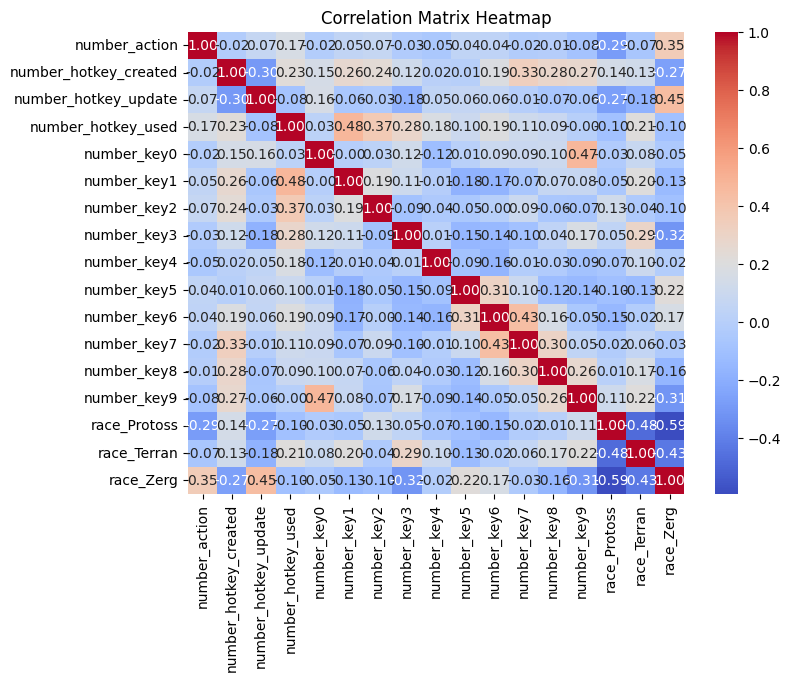

In [9]:
correlation_matrix = X.corr(method='spearman')
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, f1_score

# Define the parameter distributions for random search
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform random search with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, cv=3, scoring='f1_macro', n_iter=40, random_state=42, n_jobs=4)
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model on the test set
best_rf_model = random_search.best_estimator_


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 88}


In [11]:
y_pred = best_rf_model.predict(X_valid)

In [12]:
# Compute the F1 score
f1 = f1_score(y_valid, y_pred, average= 'macro')

# Print the F1 score
print(f1)

0.8085480523470718


number_key3              0.097412
number_key4              0.096349
number_key2              0.094826
number_key1              0.092170
number_key5              0.085048
number_hotkey_used       0.080390
number_action            0.077185
number_hotkey_created    0.069383
number_key6              0.059370
number_key0              0.058834
number_key8              0.043337
number_key7              0.039459
number_key9              0.034665
number_hotkey_update     0.034426
race_Protoss             0.014427
race_Terran              0.012249
race_Zerg                0.010471
dtype: float64


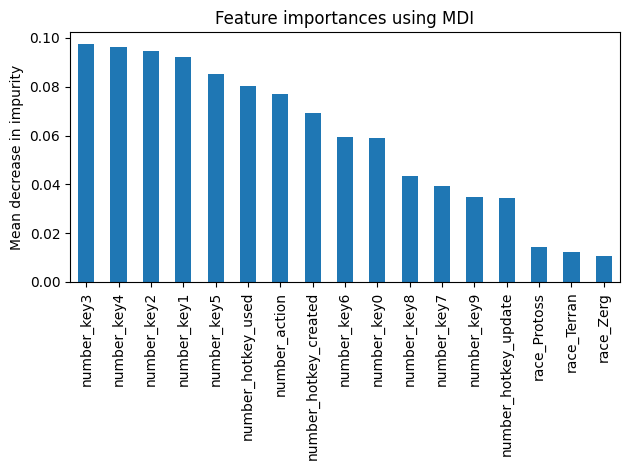

In [13]:
# Feature importances
importances = best_rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf_model.estimators_], axis=0)

feature_names = list(X_train.columns)
forest_importances = pd.Series(importances, index=feature_names)
sorted_importances = forest_importances.sort_values(ascending = False)
print(sorted_importances)

fig, ax = plt.subplots()
sorted_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [14]:
# SVM
# Standardize the features (optional but recommended for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_valid)

In [15]:
from scipy.stats import loguniform
# Define the SVM model
svm_model = SVC()

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'C': loguniform(1e-3, 1e3),        # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto', 'scale'],  # Kernel coefficient for 'rbf' kernel
    'degree': randint(2, 5),            # Degree for 'poly' kernel
    'shrinking': [True, False],         # Whether to use the shrinking heuristic
    'class_weight': [None, 'balanced'], # Class weights
}

# Create RandomizedSearchCV object
rand_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, cv=5, scoring='f1_macro', n_jobs=4)

# Fit the model to the training data
rand_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", rand_search.best_params_)
# Evaluate the model on the test set
best_svm_model = rand_search.best_estimator_


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Hyperparameters: {'C': 398.87740561303553, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': False}


In [16]:
# Make predictions on the test set
y_pred_svm = best_svm_model.predict(X_test_scaled)
# Compute the F1 score
f1 = f1_score(y_valid, y_pred_svm, average= 'macro')

# Print the F1 score
print(f1)

0.7848739876070738


In [17]:
# Create AdaBoostClassifier with DecisionTree base estimator
base_estimator = DecisionTreeClassifier(max_depth=50)
ada_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Define hyperparameter space for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),  # Number of estimators
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Learning rate
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=ada_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_macro', random_state=42, n_jobs=4)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_ada_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_ada_model.predict(X_valid)


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [18]:
# Compute the F1 score
f1 = f1_score(y_valid, y_pred, average= 'macro')

# Print the F1 score
print(f1)

0.6442688843345163


In [19]:
print(X)

      number_action  number_hotkey_created  number_hotkey_update  \
0          0.409496               0.044510                   0.0   
1          0.448071               0.044510                   0.0   
2          0.507418               0.041543                   0.0   
3          0.394659               0.032641                   0.0   
4          0.442136               0.026706                   0.0   
...             ...                    ...                   ...   
3029       0.804154               0.062315                   0.0   
3030       0.887240               0.074184                   0.0   
3031       0.729970               0.068249                   0.0   
3032       0.976261               0.068249                   0.0   
3033       0.765579               0.065282                   0.0   

      number_hotkey_used  number_key0  number_key1  number_key2  number_key3  \
0               0.771513     0.002967     0.124629     0.044510     0.462908   
1               1.15430

In [20]:
# Deep Neural Networks
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Encoding the target attribute for multi-class classification
le = LabelEncoder().fit(y)
y_enc = le.transform(y)

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y_enc, test_size=0.2, random_state=42)

# Normalize/Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Build the neural network model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(17,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')  # Multi-class, so using 'softmax'
])


In [21]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=64, batch_size=32)

Epoch 1/64
76/76 [==============================] - 1s 2ms/step - loss: 5.9315 - accuracy: 0.0148
Epoch 2/64
76/76 [==============================] - 0s 3ms/step - loss: 5.3456 - accuracy: 0.0532
Epoch 3/64
76/76 [==============================] - 0s 2ms/step - loss: 4.6737 - accuracy: 0.0977
Epoch 4/64
76/76 [==============================] - 0s 2ms/step - loss: 4.0692 - accuracy: 0.1945
Epoch 5/64
76/76 [==============================] - 0s 2ms/step - loss: 3.5639 - accuracy: 0.3033
Epoch 6/64
76/76 [==============================] - 0s 2ms/step - loss: 3.1541 - accuracy: 0.4030
Epoch 7/64
76/76 [==============================] - 0s 2ms/step - loss: 2.8377 - accuracy: 0.4817
Epoch 8/64
76/76 [==============================] - 0s 2ms/step - loss: 2.6196 - accuracy: 0.5307
Epoch 9/64
76/76 [==============================] - 0s 2ms/step - loss: 2.4602 - accuracy: 0.5752
Epoch 10/64
76/76 [==============================] - 0s 2ms/step - loss: 2.3418 - accuracy: 0.5950
Epoch 11/64
76/76 [

In [22]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Test accuracy: {accuracy:.4f}")

19/19 [==============================] - 0s 2ms/step - loss: 1.4866 - accuracy: 0.7858
Test accuracy: 0.7858


In [23]:
# Get predictions on the test set
y_pred_probs = model.predict(X_valid)

# Convert probabilities to class labels
y_pred_indices = np.argmax(y_pred_probs, axis=1)

# Inverse transform the predicted indices to original labels
decoded_labels = le.inverse_transform(y_pred_indices)

19/19 [==============================] - 0s 1ms/step


In [24]:
# 'decoded_labels' now contains the original labels predicted by the model
print(decoded_labels)

['http://us.battle.net/sc2/en/profile/4589387/1/ToodmingCN/'
 'http://us.battle.net/sc2/en/profile/4589387/1/ToodmingCN/'
 'http://kr.battle.net/sc2/en/profile/2341467/1/Classic/'
 'http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/'
 'http://kr.battle.net/sc2/en/profile/2343012/1/Maru/'
 'http://eu.battle.net/sc2/en/profile/315813/1/dBlinG/'
 'http://us.battle.net/sc2/en/profile/4417787/1/HyuN/'
 'http://us.battle.net/sc2/en/profile/2537456/1/Neeb/'
 'http://xx.battle.net/sc2/en/profile/401/1/Soulkey/'
 'http://kr.battle.net/sc2/en/profile/2342269/1/Savage/'
 'http://kr.battle.net/sc2/en/profile/2342419/1/soO/'
 'http://eu.battle.net/sc2/en/profile/950504/1/Grubby/'
 'http://kr.battle.net/sc2/en/profile/2344333/1/Leenock/'
 'http://eu.battle.net/sc2/en/profile/884897/1/LiquidSnute/'
 'http://us.battle.net/sc2/en/profile/2541852/1/MaSa/'
 'http://kr.battle.net/sc2/en/profile/2341466/1/sora/'
 'http://us.battle.net/sc2/en/profile/3985949/1/Bomber/'
 'http://kr.battle.net/sc2/en/prof

In [25]:
# 

In [26]:
# Test data preparation

test_data = "/kaggle/input/projetdm-data/TEST.CSV"
### Loop the data lines
with open(test_data, 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
df_test = pd.read_csv(test_data,header=None, delimiter=",", names=column_names, low_memory=False).astype(str)
df_test.insert(0, '0', 0)
df_test.head()

,0,0,1,2,3,4,5,6,7,8,...,6808,6809,6810,6811,6812,6813,6814,6815,6816,6817
0,0,Zerg,s,s,s,hotkey10,s,hotkey60,s,hotkey00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,Terran,s,hotkey30,hotkey00,t5,s,hotkey32,s,hotkey32,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,Protoss,Base,s,s,Base,s,hotkey20,hotkey30,hotkey60,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,Zerg,s,s,s,s,hotkey20,s,hotkey40,t5,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,Protoss,Base,s,s,Base,s,hotkey50,hotkey30,t5,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [27]:
converted_test_data = df_test.values
output_test_data = extract_features(converted_test_data, is_test = True)


In [28]:
new_test_df = pd.DataFrame(output_test_data, columns=headers)
# One-hot encode the specified columns
new_test_df = pd.get_dummies(new_test_df, columns=['race'])
X_test = new_test_df.iloc[:, 1:]  # Features (game information)
X_test = scaler.fit_transform(X_test)
predictions = model.predict(X_test)

11/11 [==============================] - 0s 2ms/step


In [29]:
len(new_test_df)

340

In [30]:
# Convert probabilities to class labels
y_pred_indices = np.argmax(predictions, axis=1)

# Inverse transform the predicted indices to original labels
decoded_labels = le.inverse_transform(y_pred_indices)
print(len(decoded_labels))

340


In [31]:
# Convert predictions to a DataFrame
submission_df = pd.DataFrame({'prediction': decoded_labels})
submission_df['RowId'] = submission_df.index + 1 # Adding row IDs starting from 0

# Reorder the columns with 'RowID' as the first column
submission_df = submission_df[['RowId', 'prediction']]


# Save the DataFrame to a CSV file named 'submissions.csv'
submission_df.to_csv('submissions.csv', index=False)  